In [5]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seawater as sw
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw
from scipy.fft import fft, fftfreq
import pandas as pd

In [6]:
mon=xr.open_dataset("SLH93-22monthly.nc")
O_T = xr.open_dataset("../ASSIGN_1_PDO/757.nc")
O_S = O_T['so_glor']
O_T = O_T['so_glor']

In [7]:
O_T

<xarray.DataArray 'so_glor' (time: 360, depth: 74, latitude: 101, longitude: 121)>
[325567440 values with dtype=float32]
Coordinates:
  * depth      (depth) float32 0.5058 1.556 2.668 ... 5.495e+03 5.698e+03
  * latitude   (latitude) float32 20.0 20.25 20.5 20.75 ... 44.5 44.75 45.0
  * longitude  (longitude) float32 120.0 120.2 120.5 120.8 ... 149.5 149.8 150.0
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2022-12-01
Attributes:
    long_name:      Salinity
    units:          1e-3
    standard_name:  sea_water_salinity
    unit_long:      Practical Salinity Unit
    valid_min:      0.0
    valid_max:      50.0

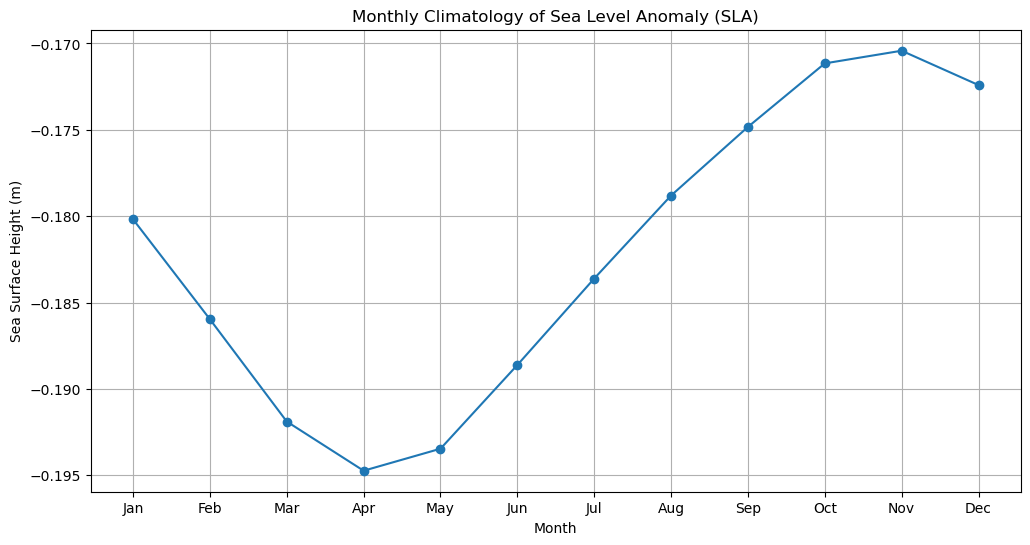

In [8]:


# Compute monthly climatology (mean for each month across all years)
sla_climatology = mon['zos_glor'].groupby('time.month').mean(dim='time')

# Plot the monthly climatology
plt.figure(figsize=(12, 6))
sla_climatology.mean(dim=['latitude', 'longitude']).plot(marker='o', linestyle='-')

# Labeling
plt.title("Monthly Climatology of Sea Level Anomaly (SLA)")
plt.xlabel("Month")
plt.ylabel("Sea Surface Height (m)")
plt.grid(True)
plt.xticks(ticks=range(1, 13), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                                       "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

plt.show()



/tmp/ipykernel_4722/31934679.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbar


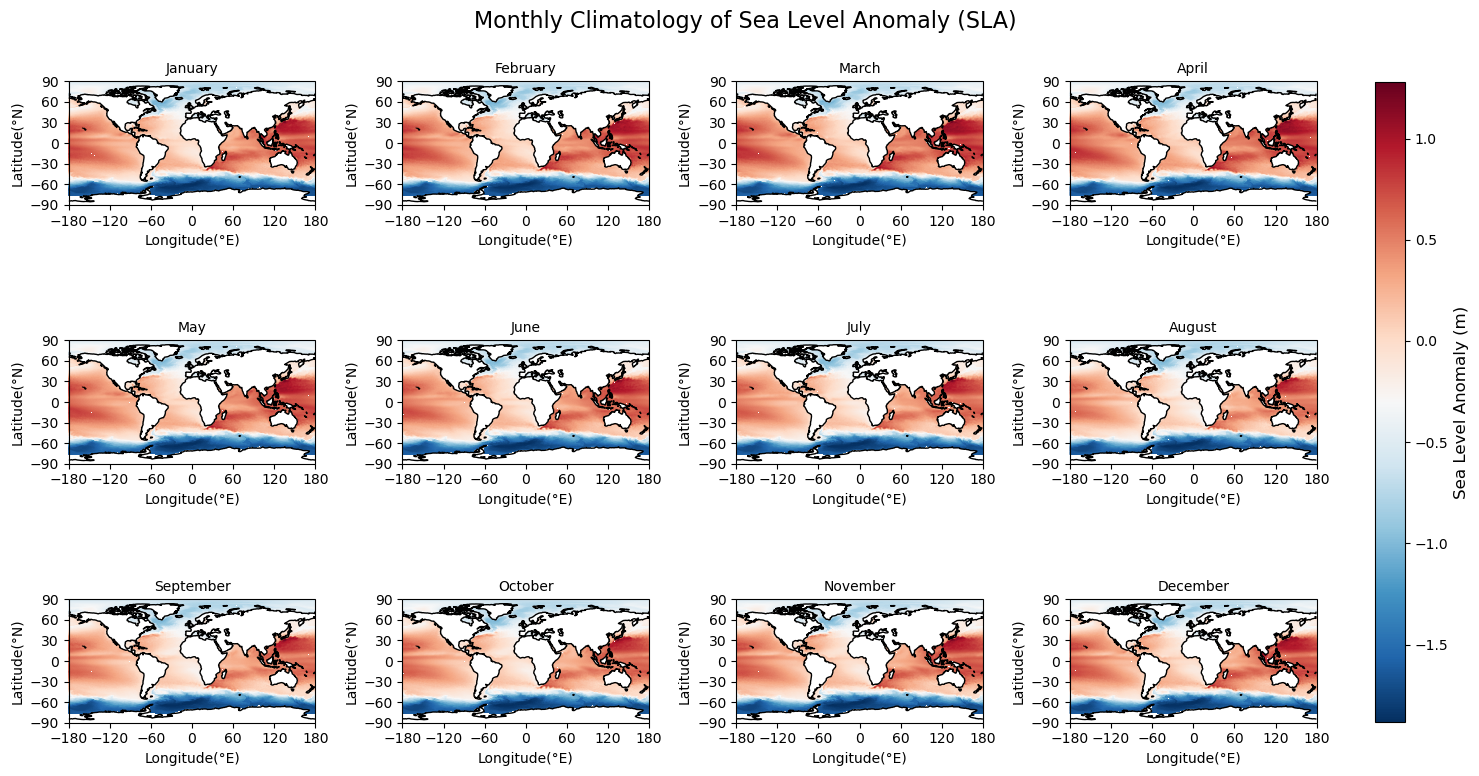

In [12]:


# Compute monthly climatology (mean for each month across all years)
sla_climatology = mon['zos_glor'].groupby('time.month').mean(dim='time')

# Create a 3x4 subplot for the 12 months
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 8),subplot_kw={'projection': ccrs.PlateCarree()})

# Define month labels
month_labels = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

# Longitude and Latitude values for ticks
lon_ticks = range(-180, 181, 60)  # Longitude from -180° to 180° in 60° intervals
lat_ticks = range(-90, 91, 30)    # Latitude from -90° to 90° in 30° intervals

# Loop through each month and plot
for i, ax in enumerate(axes.flat):
    im = ax.pcolormesh(mon['longitude'], mon['latitude'], sla_climatology.sel(month=i+1), cmap='RdBu_r', shading='auto', transform=ccrs.PlateCarree())
    
    # Add coastlines and gridlines with labels
    ax.coastlines()
    # gl = ax.gridlines(draw_labels=True, linestyle="--", alpha=0.5)
    # gl.right_labels = False  # Remove right labels
    # gl.top_labels = False  # Remove top labels
    
    # Set X and Y labels for every subplot
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())

    # Set X and Y labels for EVERY subplot
    ax.set_xlabel("Longitude(°E)", fontsize=10)
    ax.set_ylabel("Latitude(°N)", fontsize=10)
    
    # Set title for each month
    ax.set_title(month_labels[i], fontsize=10)

# Add a colorbar
cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.8])  # Position for colorbar
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Sea Level Anomaly (m)", fontsize=12)  # Colorbar label

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbar
plt.suptitle("Monthly Climatology of Sea Level Anomaly (SLA)", fontsize=16, y=1)
plt.show()



/tmp/ipykernel_4722/4294756541.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


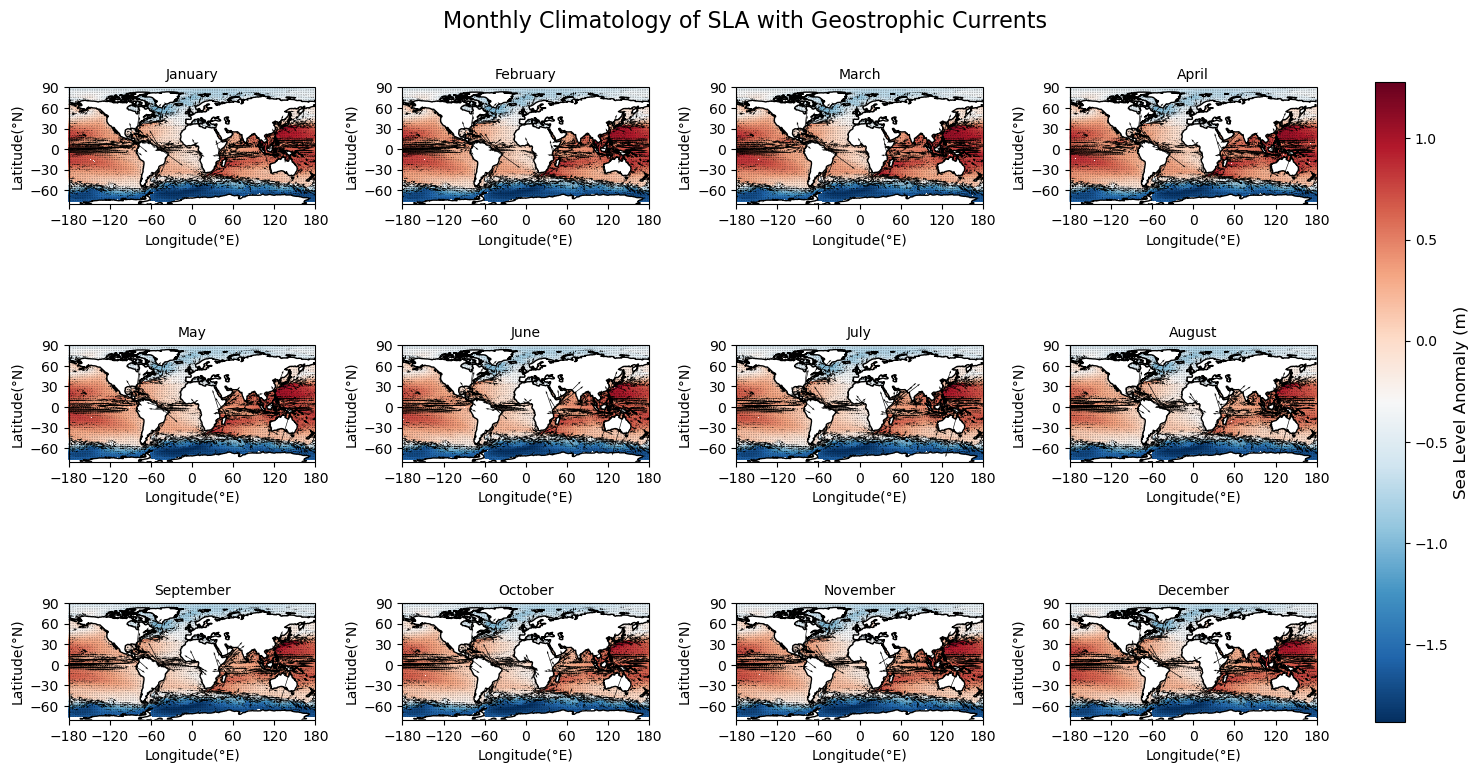

In [13]:
# import xarray as xr
# import numpy as np
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature

# # Load dataset
# mon = xr.open_dataset("SLH93-22monthly.nc")

# # Compute monthly climatology (mean for each month across all years)
# sla_climatology = mon['zos_glor'].groupby('time.month').mean(dim='time')

# Constants
g = 9.81  # Gravity (m/s²)
Omega = 7.2921e-5  # Earth's rotation rate (rad/s)
latitudes = mon['latitude']
longitudes = mon['longitude']


dx = 111000 * np.cos(np.deg2rad(latitudes))  # Convert degrees to meters (longitude)
dy = 106000  # Approximate 1° latitude in meters

# Compute Coriolis parameter f = 2Ω sin(latitude)
f = 2 * Omega * np.sin(np.deg2rad(latitudes))

f=f.where(f!=0)

# Compute gradients
dSLA_dx = sla_climatology.differentiate("longitude") / dx  # SLA gradient in x-direction
dSLA_dy = sla_climatology.differentiate("latitude") / dy   # SLA gradient in y-direction

# Compute geostrophic currents
Ug = -g * dSLA_dy / f  # Zonal velocity (eastward)
Vg = g * dSLA_dx / f    # Meridional velocity (northward)

# Create a 3x4 subplot for the 12 months
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Define month labels
month_labels = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

# Longitude and Latitude values for ticks
lon_ticks = range(-180, 181, 60)
lat_ticks = range(-90, 91, 30)

# Loop through each month and plot
for i, ax in enumerate(axes.flat):
    im = ax.pcolormesh(mon['longitude'], mon['latitude'], sla_climatology.sel(month=i+1), cmap='RdBu_r', shading='auto', transform=ccrs.PlateCarree())

    # Add coastlines and gridlines
    ax.coastlines()
    #gl = ax.gridlines(draw_labels=True, linestyle="--", alpha=0.5)
    # gl.right_labels = False
    # gl.top_labels = False

    # Set X and Y labels for every subplot
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())

    
    # Set X and Y labels for EVERY subplot
    ax.set_xlabel("Longitude(°E)", fontsize=10)
    ax.set_ylabel("Latitude(°N)", fontsize=10)
    
    # Set title for each month
    ax.set_title(month_labels[i], fontsize=10)
    
    # Overlay geostrophic current vectors (quiver plot)
    q = ax.quiver(mon['longitude'][::10], mon['latitude'][::10], 
                  Ug.sel(month=i+1)[::10, ::10], Vg.sel(month=i+1)[::10, ::10], 
                  transform=ccrs.PlateCarree(), color='black', scale=10)

# Add a colorbar
cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Sea Level Anomaly (m)", fontsize=12)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.suptitle("Monthly Climatology of SLA with Geostrophic Currents", fontsize=16, y=1)
plt.show()


In [14]:
np.nanmin(Ug)

-12.60323934216339

/tmp/ipykernel_4722/2900748558.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


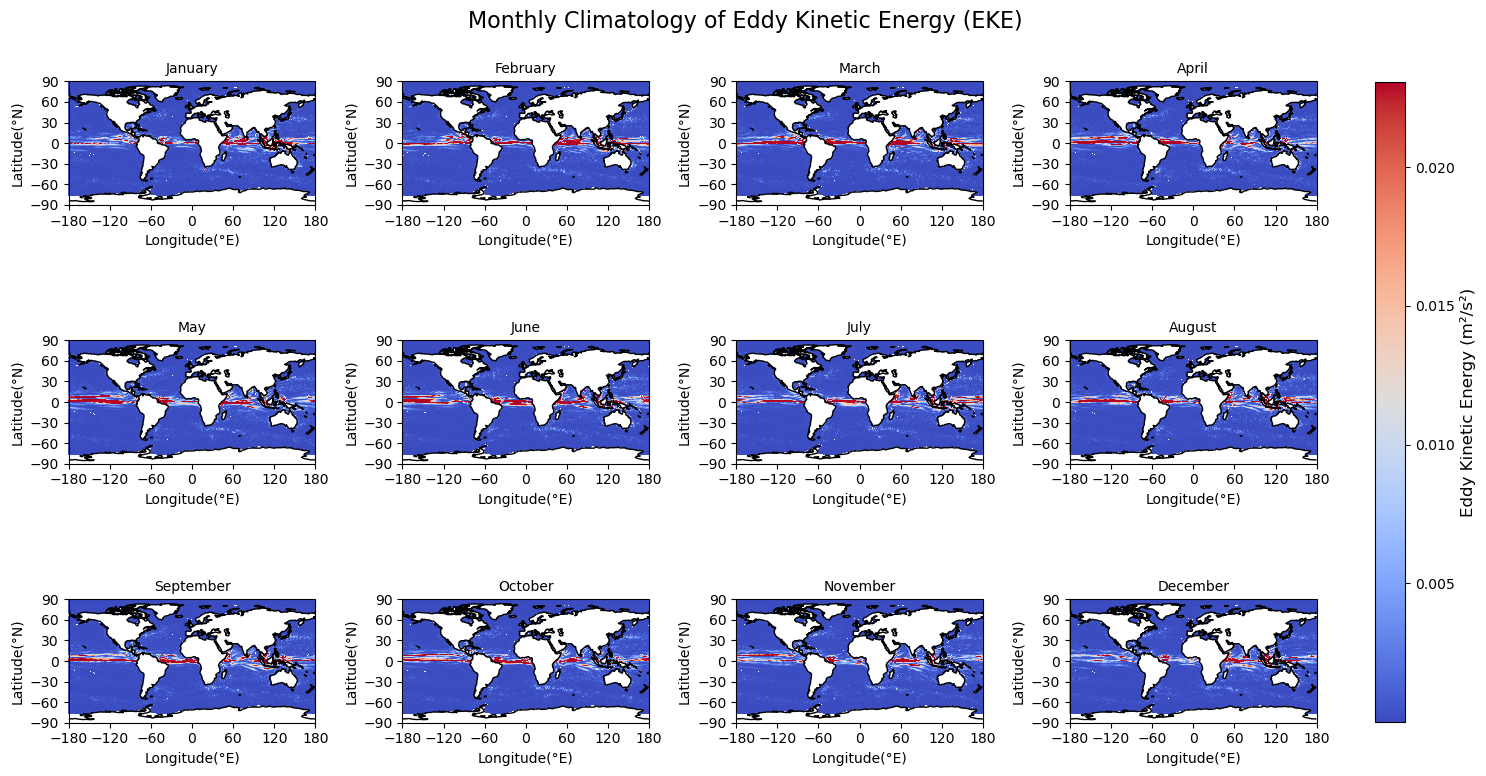

In [15]:
# import xarray as xr
# import numpy as np
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature

# # Load dataset
# mon = xr.open_dataset("SLH93-22monthly.nc")

# # Compute monthly climatology of SLA
# sla_climatology = mon['zos_glor'].groupby('time.month').mean(dim='time')

# # Constants
# g = 9.81  # Gravity (m/s²)
# Omega = 7.2921e-5  # Earth's rotation rate (rad/s)
# latitudes = mon['latitude']
# longitudes = mon['longitude']
# dx = 111000 * np.cos(np.deg2rad(latitudes))  # Convert degrees to meters (longitude)
# dy = 111000  # Approximate 1° latitude in meters

# # Compute Coriolis parameter f = 2Ω sin(latitude)
# f = 2 * Omega * np.sin(np.deg2rad(latitudes))

# # Compute gradients
# dSLA_dx = sla_climatology.differentiate("longitude") / dx  # SLA gradient in x-direction
# dSLA_dy = sla_climatology.differentiate("latitude") / dy   # SLA gradient in y-direction

# # Compute geostrophic currents
# Ug = -g * dSLA_dy / f  # Zonal velocity (eastward)
# Vg = g * dSLA_dx / f    # Meridional velocity (northward)

# Compute monthly mean geostrophic currents
Ug_clim = Ug.mean(dim="month")
Vg_clim = Vg.mean(dim="month")

# Compute eddy geostrophic velocity anomalies
Ug_prime = Ug - Ug_clim
Vg_prime = Vg - Vg_clim

# Compute Eddy Kinetic Energy (EKE)
EKE = 0.5 * (Ug_prime**2 + Vg_prime**2)

# # Determine global min/max EKE for consistent color range
# EKE_min = EKE.min().values
# EKE_max = EKE.max().values
EKE_min = EKE.quantile(0.02).values  # 2nd percentile to avoid near-zero values
EKE_max = EKE.quantile(0.98).values  # 98th percentile to exclude extreme peaks

# Create a 3x4 subplot for the 12 months
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Define month labels
month_labels = ["January", "February", "March", "April", "May", "June", 
                "July", "August", "September", "October", "November", "December"]

# Longitude and Latitude values for ticks
lon_ticks = range(-180, 181, 60)
lat_ticks = range(-90, 91, 30)

# Loop through each month and plot
for i, ax in enumerate(axes.flat):
    im = ax.pcolormesh(mon['longitude'], mon['latitude'], EKE.sel(month=i+1), 
                        cmap='coolwarm', vmin=EKE_min, vmax=EKE_max, shading='auto', transform=ccrs.PlateCarree())

    # Add coastlines and gridlines
    ax.coastlines()
    #gl = ax.gridlines(draw_labels=True, linestyle="--", alpha=0.5)
    # gl.right_labels = False
    # gl.top_labels = False

     # Set X and Y labels for every subplot
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    
    # Set X and Y labels for EVERY subplot
    ax.set_xlabel("Longitude(°E)", fontsize=10)
    ax.set_ylabel("Latitude(°N)", fontsize=10)
    
    # Set title for each month
    ax.set_title(month_labels[i], fontsize=10)

# Add a colorbar
cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Eddy Kinetic Energy (m²/s²)", fontsize=12)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.suptitle("Monthly Climatology of Eddy Kinetic Energy (EKE)", fontsize=16, y=1)
plt.show()


In [16]:
print(EKE.min().values, EKE.max().values)


1.788262527944461e-14 69.86077882023757


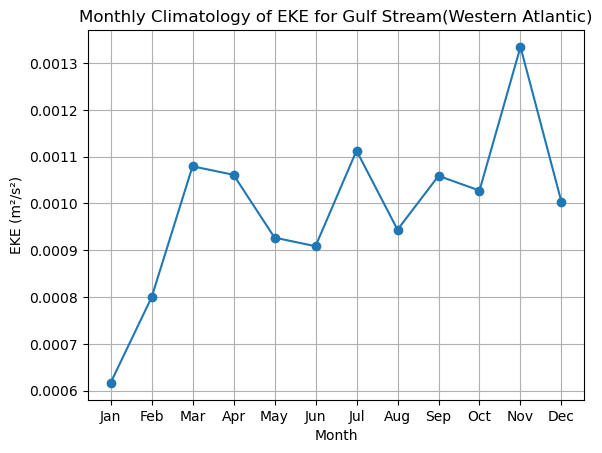

In [17]:
lat_range = slice(30, 45)  # Gulf stream
lon_range = slice(-80, -60)
EKE_region = EKE.sel(latitude=lat_range, longitude=lon_range).mean(dim=["latitude", "longitude"])

plt.plot(EKE_region["month"], EKE_region, marker="o", linestyle="-")
plt.xlabel("Month")
plt.ylabel("EKE (m²/s²)")
plt.title("Monthly Climatology of EKE for Gulf Stream(Western Atlantic)")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.grid()
plt.show()


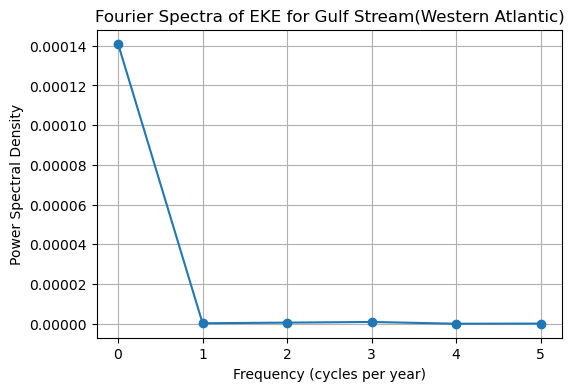

In [18]:
import numpy as np
# Apply Fourier Transform
eke_values = EKE_region.values  # Extract values
fft_values = np.fft.fft(eke_values)  # Compute FFT
freqs = np.fft.fftfreq(len(eke_values), d=1/12)  # Monthly frequency in cycles per year
power_spectrum = np.abs(fft_values) ** 2  # Compute Power Spectral Density (PSD)

# Plot the Fourier Spectra
plt.figure(figsize=(6, 4))
plt.plot(freqs[:6], power_spectrum[:6], marker="o", linestyle="-")
plt.xlabel("Frequency (cycles per year)")
plt.ylabel("Power Spectral Density")
plt.title("Fourier Spectra of EKE for Gulf Stream(Western Atlantic)")
plt.grid()
plt.show()




/home/mohit/anaconda3/lib/python3.12/site-packages/xarray/core/groupby.py:508: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


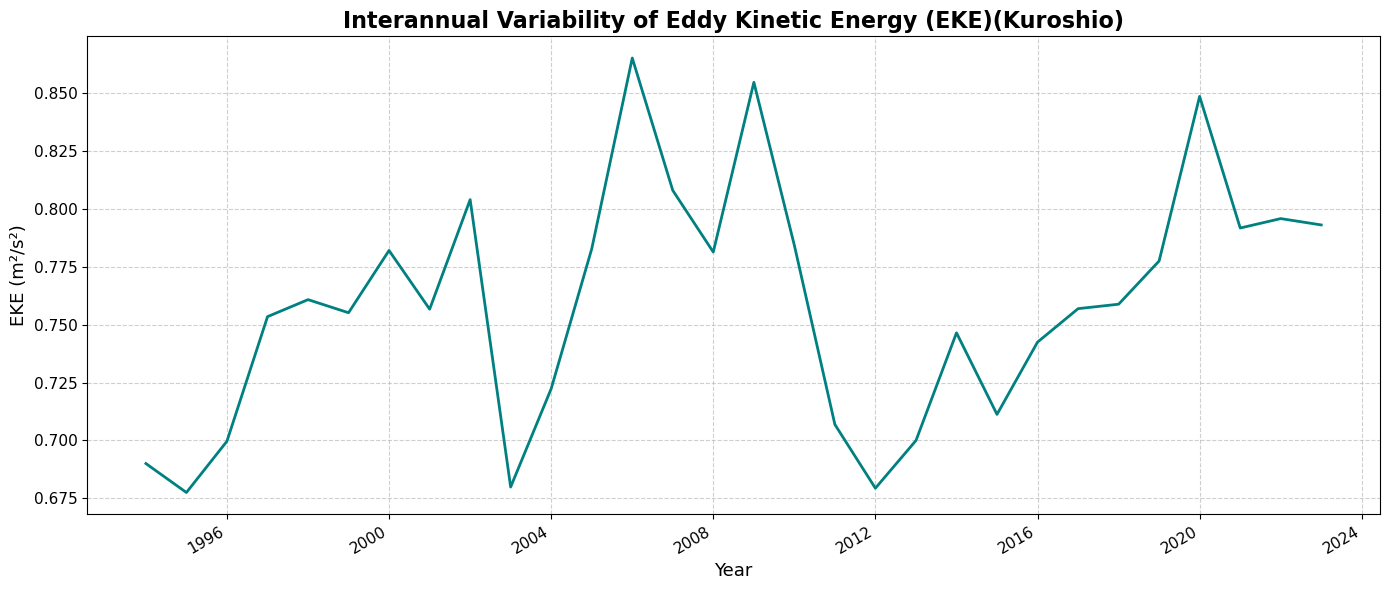

In [24]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
SSH_gs = xr.open_dataset('../ASSIGN_1_PDO/wokslh.nc')
ssh_gs = SSH_gs['zos_glor']  
time_gs = SSH_gs['time']

# Constants
g = 9.81  # m/s^2
R = 6371000  # Earth radius in meters
omega = 7.2921e-5  # Earth's angular velocity

# Get lat/lon spacing in meters
lat_gs = SSH_gs['latitude']
lon_gs = SSH_gs['longitude']
dlat_gs = np.deg2rad(lat_gs[1] - lat_gs[0])
dlon_gs = np.deg2rad(lon_gs[1] - lon_gs[0])
dx_gs = R * np.cos(np.deg2rad(lat_gs)) * dlon_gs
dy_gs = R * dlat_gs

# Calculate Coriolis parameter
f_gs = 2 * omega * np.sin(np.deg2rad(lat_gs))
f_gs = f_gs.broadcast_like(ssh_gs)

# Compute gradients
dssh_dy = ssh_gs.differentiate('latitude') / dy_gs
dssh_dx = ssh_gs.differentiate('longitude') / dx_gs

# Compute geostrophic velocities
u_gs = -g / f_gs * dssh_dy
v_gs = g / f_gs * dssh_dx

# Compute Eddy Kinetic Energy (EKE)
eke_gs = 0.5 * (u_gs**2 + v_gs**2)

# Area average over region (e.g., Gulf Stream)
eke_mean_gs = eke_gs.mean(dim=('latitude', 'longitude'))

# Resample to annual mean
eke_annual_gs = eke_mean_gs.resample(time='1Y').mean()

# Plot EKE time series with decoration
plt.figure(figsize=(14, 6))
eke_annual_gs.plot(color='teal', linewidth=2)

plt.title('Interannual Variability of Eddy Kinetic Energy (EKE)(Kuroshio)', fontsize=16, weight='bold')
plt.ylabel('EKE (m²/s²)', fontsize=13)
plt.xlabel('Year', fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


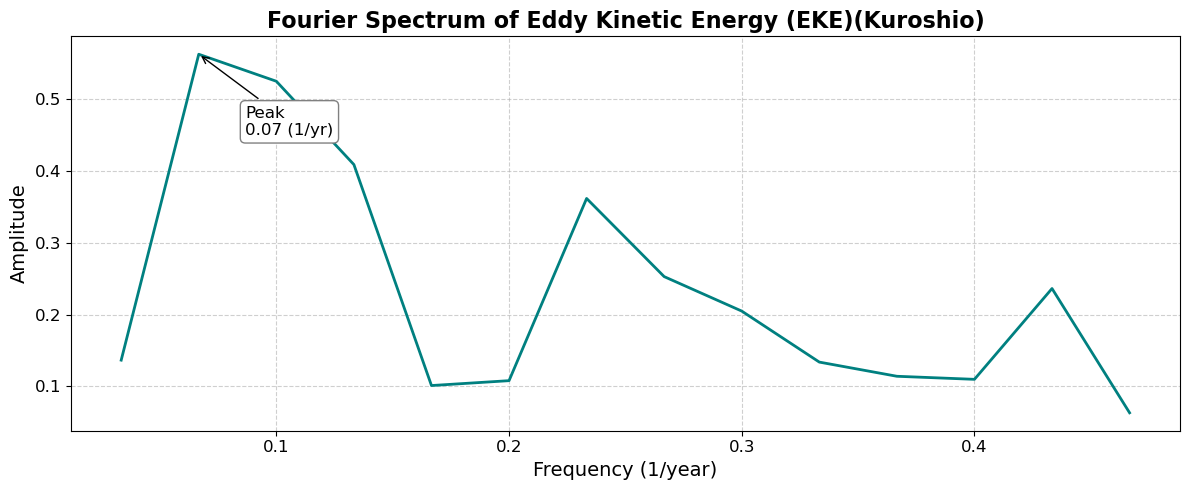

In [25]:
from scipy.fft import fft, fftfreq
import numpy as np
import matplotlib.pyplot as plt

n = len(eke_annual_gs)
dt = 1  # 1 year sampling interval

# Convert xarray to numpy
eke_vals = eke_annual_gs.values
fft_vals = fft(eke_vals - np.mean(eke_vals))
freq = fftfreq(n, dt)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(freq[1:n//2], np.abs(fft_vals[1:n//2]), color='teal', linewidth=2)

# Titles and labels
plt.title('Fourier Spectrum of Eddy Kinetic Energy (EKE)(Kuroshio)', fontsize=16, fontweight='bold')
plt.xlabel('Frequency (1/year)', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)

# Grid and ticks
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Highlight peak frequency
peak_idx = np.argmax(np.abs(fft_vals[1:n//2]))
peak_freq = freq[1:n//2][peak_idx]
peak_amp = np.abs(fft_vals[1:n//2])[peak_idx]
plt.annotate(f'Peak\n{peak_freq:.2f} (1/yr)', xy=(peak_freq, peak_amp),
             xytext=(peak_freq + 0.02, peak_amp * 0.8),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='white'))

# Tight layout
plt.tight_layout()
plt.show()


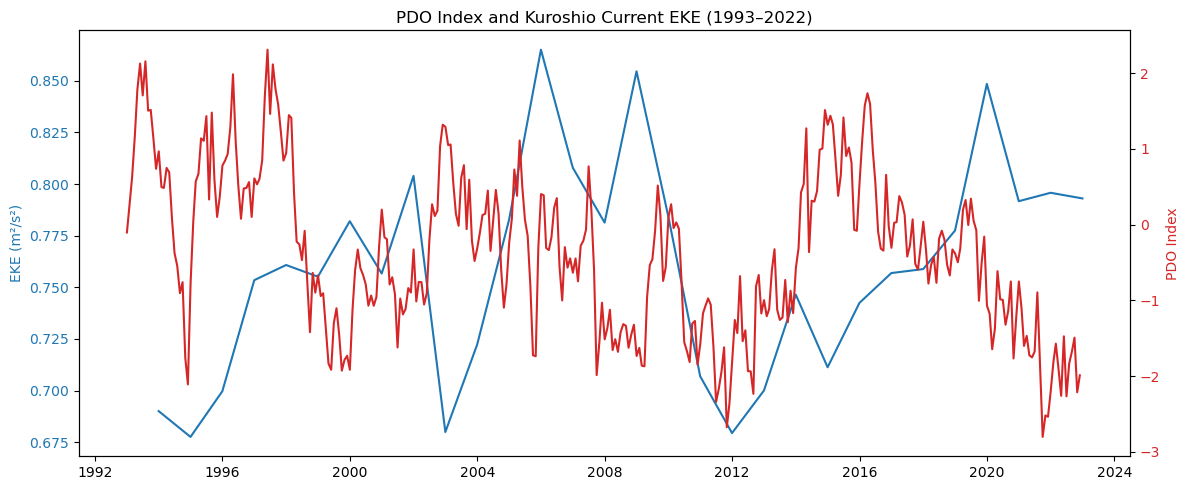

In [22]:
pdo=xr.open_dataset("pdo.timeseries.sstens.nc")
pdo=pdo.sel(time=slice("1993-01-01", "2022-12-01"))['pdo']
# pdo.plot()
# eke_annual_gs.plot()

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot EKE on the left y-axis
color1 = 'tab:blue'
ax1.set_ylabel('EKE (m²/s²)', color=color1)
ax1.plot(eke_annual_gs.time, eke_annual_gs, color=color1, label='EKE')
ax1.tick_params(axis='y', labelcolor=color1)

# Create a second y-axis for PDO
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_xlabel('Time')
ax2.set_ylabel('PDO Index', color=color2)
ax2.plot(pdo.time, pdo, color=color2, label='PDO')
ax2.tick_params(axis='y', labelcolor=color2)

# Title and layout
plt.title('PDO Index and Kuroshio Current EKE (1993–2022)')
fig.tight_layout()
plt.grid(True, axis='x')
plt.show()


/tmp/ipykernel_4722/3880697607.py:7: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  pdo_annual_dec = pdo_series.resample('A').mean()  # or .last() if you want just December values


Pearson correlation: -0.24 (p = 0.195)


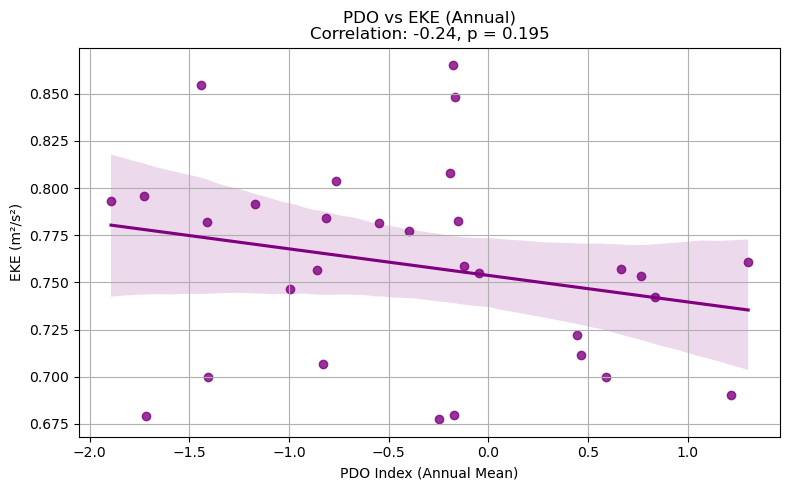

In [23]:
import pandas as pd

# Convert PDO to a pandas Series
pdo_series = pd.Series(pdo.values, index=pd.to_datetime(pdo.time.values))

# Resample PDO to annual using the last month of each year to match Dec 31
pdo_annual_dec = pdo_series.resample('A').mean()  # or .last() if you want just December values

# Align to EKE time (which ends on Dec 31 each year)
eke_series = pd.Series(eke_annual_gs.values, index=pd.to_datetime(eke_annual_gs.time.values))

# Align both datasets to common years
common_index = eke_series.index.intersection(pdo_annual_dec.index)
pdo_aligned = pdo_annual_dec[common_index]
eke_aligned = eke_series[common_index]

# ✅ Now proceed with correlation plot
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation
corr, pval = pearsonr(pdo_aligned, eke_aligned)
print(f"Pearson correlation: {corr:.2f} (p = {pval:.3f})")

# Scatter plot with regression line
plt.figure(figsize=(8, 5))
sns.regplot(x=pdo_aligned, y=eke_aligned, color='purple')
plt.xlabel('PDO Index (Annual Mean)')
plt.ylabel('EKE (m²/s²)')
plt.title(f'PDO vs EKE (Annual)\nCorrelation: {corr:.2f}, p = {pval:.3f}')
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_265924/2480571467.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='PDO Phase', y='EKE', data=df, palette=["skyblue", "salmon"])


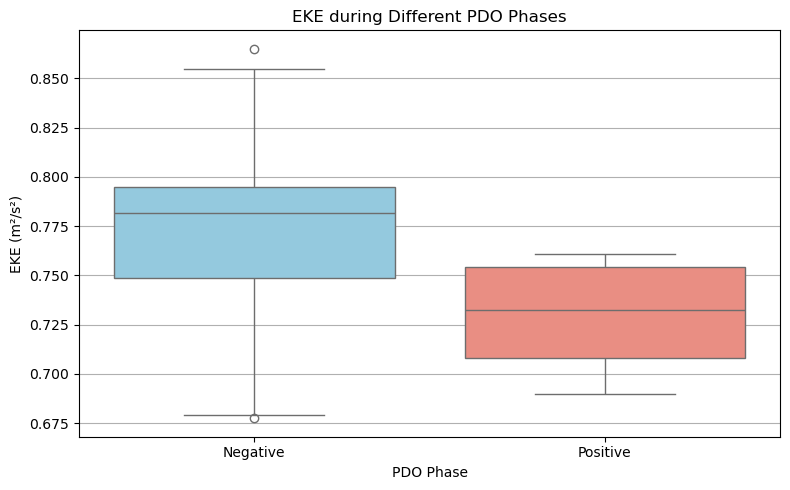

Mean EKE during PDO Negative: 0.769
Mean EKE during PDO Positive: 0.730


In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame for easy plotting
import pandas as pd

df = pd.DataFrame({
    'EKE': list(eke_neg) + list(eke_pos),
    'PDO Phase': ['Negative'] * len(eke_neg) + ['Positive'] * len(eke_pos)
})

# Plot boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x='PDO Phase', y='EKE', data=df, palette=["skyblue", "salmon"])
plt.title('EKE during Different PDO Phases')
plt.ylabel('EKE (m²/s²)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Optional: print means
print(f"Mean EKE during PDO Negative: {eke_neg.mean():.3f}")
print(f"Mean EKE during PDO Positive: {eke_pos.mean():.3f}")


/tmp/ipykernel_410866/2103921115.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  enso = pd.read_csv(


Pearson correlation: -0.20 (p = 0.290)


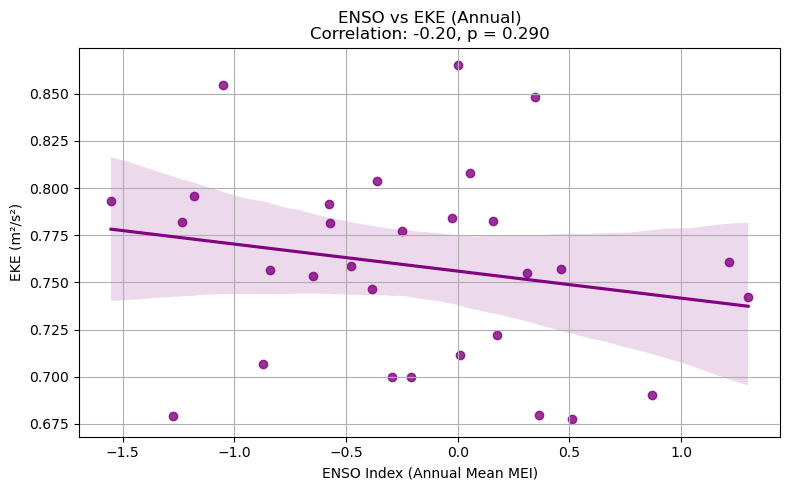

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Load ENSO (MEI v2) data
enso = pd.read_csv(
    "meiv2.data",
    delim_whitespace=True,
    names=['YEAR','JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'],
    index_col=0,
    skiprows=15,
    skipfooter=7,
    engine='python'
)

# Reshape to long format and drop missing
enso_long = enso.reset_index().melt(id_vars='YEAR', var_name='MONTH', value_name='MEI')
enso_long = enso_long.dropna()

# Calculate annual mean MEI
enso_annual = enso_long.groupby('YEAR')['MEI'].mean()

# Convert to pandas Series with datetime index (ending on Dec 31 each year)
enso_series = pd.Series(enso_annual.values, index=pd.to_datetime(enso_annual.index.astype(str) + '-12-31'))

# Convert EKE to pandas Series (already annual)
eke_series = pd.Series(eke_annual_gs.values, index=pd.to_datetime(eke_annual_gs.time.values))

# Align both to common years
common_index = eke_series.index.intersection(enso_series.index)
enso_aligned = enso_series[common_index]
eke_aligned = eke_series[common_index]

# Compute Pearson correlation
corr, pval = pearsonr(enso_aligned, eke_aligned)
print(f"Pearson correlation: {corr:.2f} (p = {pval:.3f})")

# Scatter plot with regression line
plt.figure(figsize=(8, 5))
sns.regplot(x=enso_aligned, y=eke_aligned, color='purple')
plt.xlabel('ENSO Index (Annual Mean MEI)')

plt.ylabel('EKE (m²/s²)')
plt.title(f'ENSO vs EKE (Annual)\nCorrelation: {corr:.2f}, p = {pval:.3f}')
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_265924/1781002547.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='ENSO Phase', y='EKE', data=df_enso, palette=["deepskyblue", "tomato"])


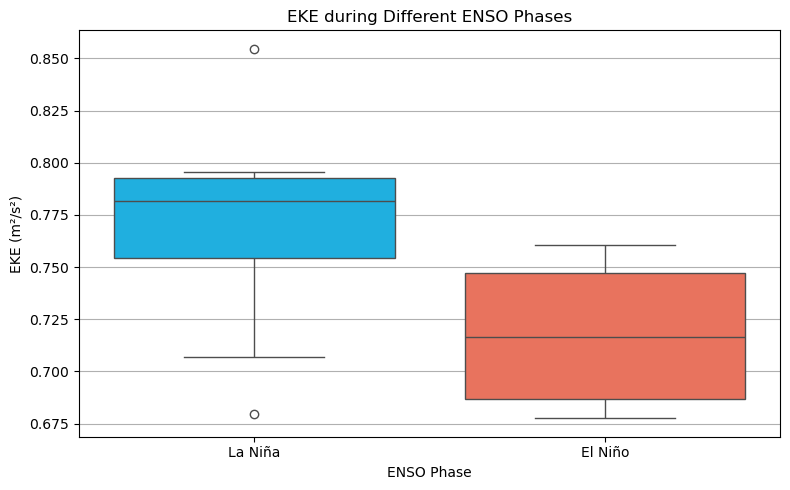

Mean EKE during El Niño: 0.718
Mean EKE during La Niña: 0.769


In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ENSO threshold: classify years into El Niño (MEI > 0.5) and La Niña (MEI < -0.5)
elnino_years = enso_series[enso_series > 0.5].index
lanina_years = enso_series[enso_series < -0.5].index

# Select corresponding EKE values
eke_elnino = eke_series[eke_series.index.isin(elnino_years)]
eke_lanina = eke_series[eke_series.index.isin(lanina_years)]

# Prepare DataFrame for boxplot
df_enso = pd.DataFrame({
    'EKE': list(eke_lanina) + list(eke_elnino),
    'ENSO Phase': ['La Niña'] * len(eke_lanina) + ['El Niño'] * len(eke_elnino)
})

# Plot boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x='ENSO Phase', y='EKE', data=df_enso, palette=["deepskyblue", "tomato"])
plt.title('EKE during Different ENSO Phases')
plt.ylabel('EKE (m²/s²)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Optional: print means
print(f"Mean EKE during El Niño: {eke_elnino.mean():.3f}")
print(f"Mean EKE during La Niña: {eke_lanina.mean():.3f}")


/tmp/ipykernel_265924/2546547421.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  enso=pd.read_csv("meiv2.data", delim_whitespace=True, names=['YEAR','JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'],index_col=0, skiprows=15, skipfooter=7, engine='python')


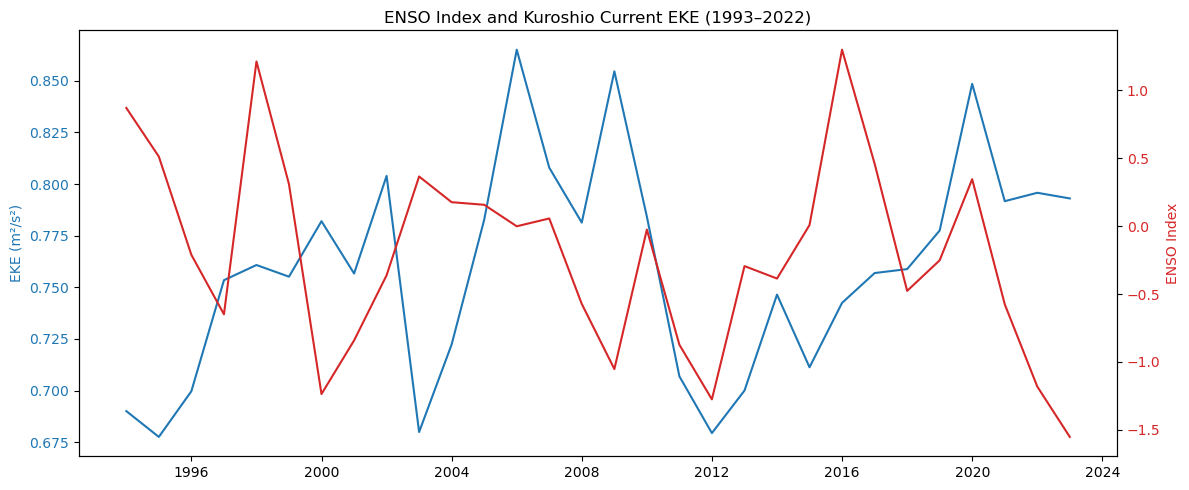

In [40]:
enso=pd.read_csv("meiv2.data", delim_whitespace=True, names=['YEAR','JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'],index_col=0, skiprows=15, skipfooter=7, engine='python')
# Melt the DataFrame to long format
enso_long = enso.reset_index().melt(id_vars='YEAR', var_name='MONTH', value_name='MEI')

# Drop missing values (if any)
enso_long = enso_long.dropna()

enso_annual = enso_long.groupby('YEAR')['MEI'].mean()


#enso_annual.plot(title='Annual Mean MEI (ENSO)', figsize=(10, 4), grid=True, ylabel='MEI')

fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot EKE on the left y-axis
color1 = 'tab:blue'
ax1.set_ylabel('EKE (m²/s²)', color=color1)
ax1.plot(eke_annual_gs.time, eke_annual_gs, color=color1, label='EKE')
ax1.tick_params(axis='y', labelcolor=color1)

# Create a second y-axis for ENSO
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_xlabel('Time')
ax2.set_ylabel('ENSO Index', color=color2)
ax2.plot(eke_annual_gs.time, enso_annual, color=color2, label='ENSO')
ax2.tick_params(axis='y', labelcolor=color2)

# Title and layout
plt.title('ENSO Index and Kuroshio Current EKE (1993–2022)')
fig.tight_layout()
plt.grid(True, axis='x')
plt.show()


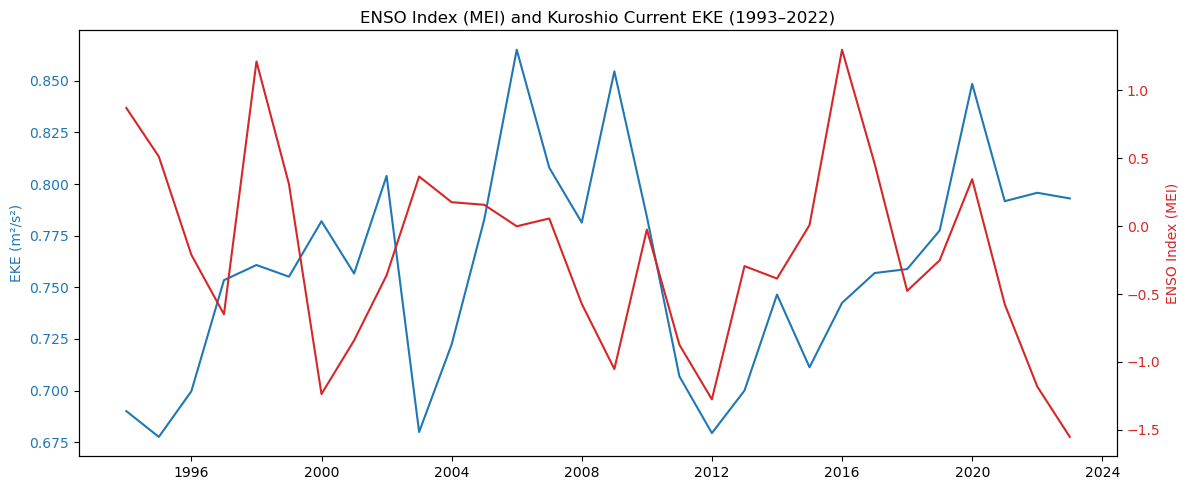

In [16]:
import matplotlib.pyplot as plt

# Convert enso_annual index (years) to datetime format for alignment
enso_annual.index = pd.to_datetime(enso_annual.index.astype(str) + '-12-31')

# Ensure alignment by checking for common dates
common_times = eke_annual_gs.time.to_index().intersection(enso_annual.index)
eke_common = eke_annual_gs.sel(time=common_times)
enso_common = enso_annual.loc[common_times]

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot EKE on the left y-axis
color1 = 'tab:blue'
ax1.set_ylabel('EKE (m²/s²)', color=color1)
ax1.plot(common_times, eke_common, color=color1, label='EKE')
ax1.tick_params(axis='y', labelcolor=color1)

# Create a second y-axis for ENSO
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_xlabel('Time')
ax2.set_ylabel('ENSO Index (MEI)', color=color2)
ax2.plot(common_times, enso_common, color=color2, label='ENSO')
ax2.tick_params(axis='y', labelcolor=color2)

# Title and layout
plt.title('ENSO Index (MEI) and Kuroshio Current EKE (1993–2022)')
fig.tight_layout()
plt.grid(True, axis='x')
plt.show()


Pearson correlation: -0.20 (p = 0.290)


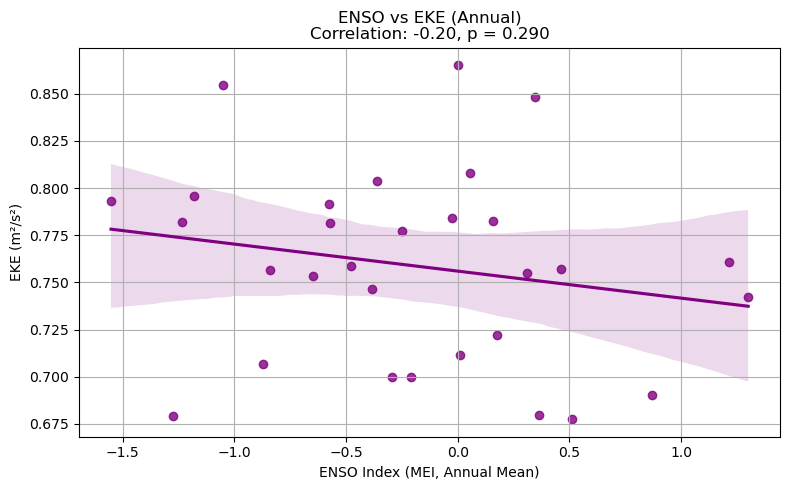

In [17]:
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate Pearson correlation
corr, pval = pearsonr(enso_common, eke_common)
print(f"Pearson correlation: {corr:.2f} (p = {pval:.3f})")

# Scatter plot with regression line
plt.figure(figsize=(8, 5))
sns.regplot(x=enso_common, y=eke_common, color='purple')
plt.xlabel('ENSO Index (MEI, Annual Mean)')
plt.ylabel('EKE (m²/s²)')
plt.title(f'ENSO(MEI) vs EKE (Annual)\nCorrelation: {corr:.2f}, p = {pval:.3f}')
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_265924/296616202.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='ENSO Phase', y='EKE', data=df_enso, palette=["deepskyblue", "tomato"])


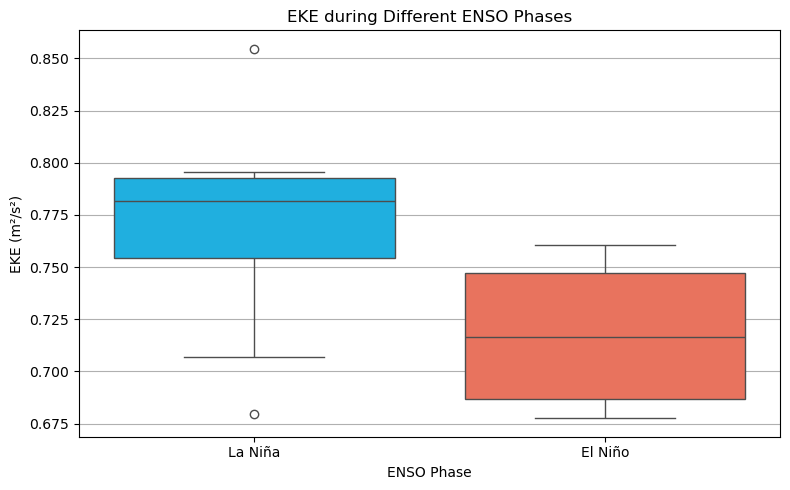

Mean EKE during El Niño: 0.718
Mean EKE during La Niña: 0.769


In [54]:
# Define ENSO phases based on MEI thresholds
elnino_years = enso_common[enso_common > 0.5].index
lanina_years = enso_common[enso_common < -0.5].index

# Select corresponding EKE values
eke_elnino = eke_common.sel(time=elnino_years)
eke_lanina = eke_common.sel(time=lanina_years)

# Create DataFrame for boxplot
import pandas as pd

df_enso = pd.DataFrame({
    'EKE': list(eke_lanina.values) + list(eke_elnino.values),
    'ENSO Phase': ['La Niña'] * len(eke_lanina) + ['El Niño'] * len(eke_elnino)
})

# Plot boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x='ENSO Phase', y='EKE', data=df_enso, palette=["deepskyblue", "tomato"])
plt.title('EKE during Different ENSO Phases')
plt.ylabel('EKE (m²/s²)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Print mean EKE values
print(f"Mean EKE during El Niño: {eke_elnino.mean().item():.3f}")
print(f"Mean EKE during La Niña: {eke_lanina.mean().item():.3f}")


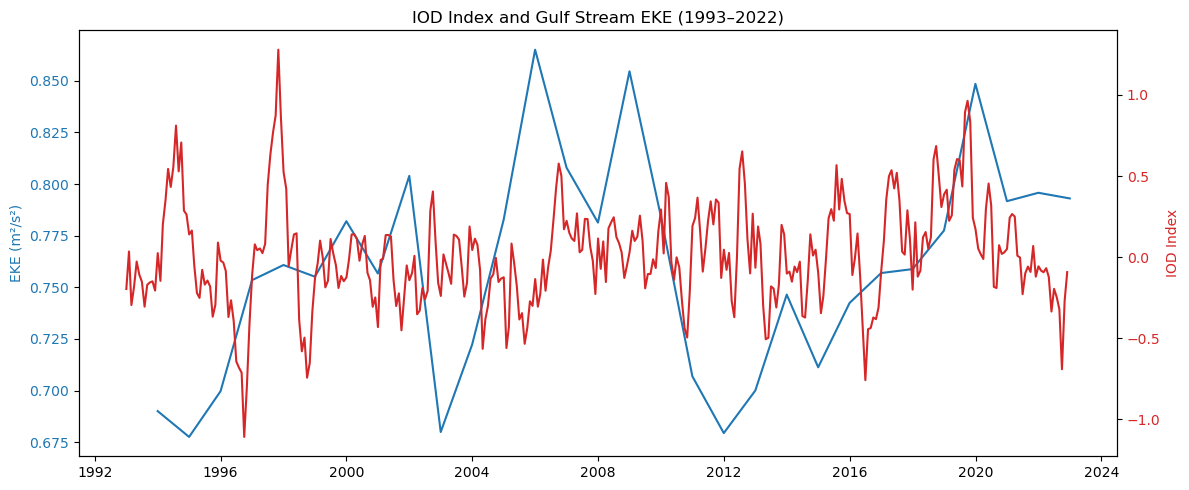

In [32]:
dmi=xr.open_dataset("dmi.had.long.nc")

dmi=dmi.sel(time=slice("1993-01-01", "2022-12-01"))['value']

fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot EKE on the left y-axis
color1 = 'tab:blue'
ax1.set_ylabel('EKE (m²/s²)', color=color1)
ax1.plot(eke_annual_gs.time, eke_annual_gs, color=color1, label='EKE')
ax1.tick_params(axis='y', labelcolor=color1)

# Create a second y-axis for DMI
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_xlabel('Time')
ax2.set_ylabel('IOD Index', color=color2)
ax2.plot(dmi.time, dmi, color=color2, label='IOD')
ax2.tick_params(axis='y', labelcolor=color2)

# Title and layout
plt.title('IOD Index and Kuroshio Current EKE (1993–2022)')
fig.tight_layout()
plt.grid(True, axis='x')
plt.show()


/tmp/ipykernel_265924/3997282437.py:11: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  dmi_annual = dmi_series.resample('A').mean()


Pearson correlation: 0.01 (p = 0.966)


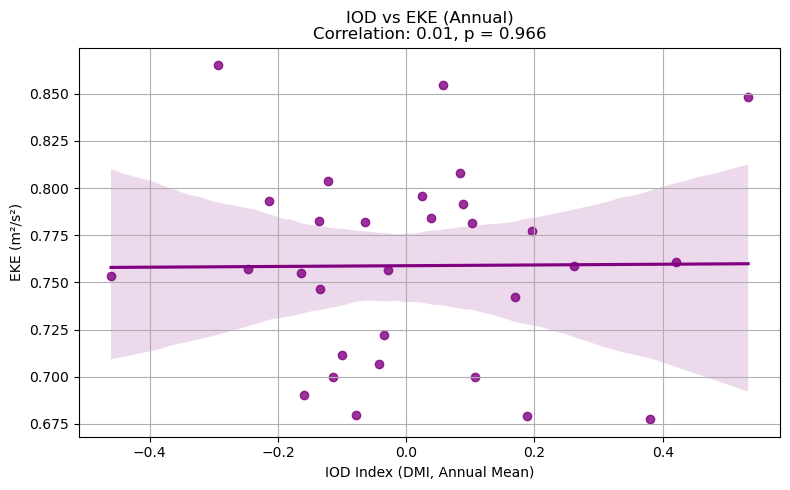

In [55]:
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

# Convert DMI and EKE to pandas Series with datetime index
dmi_series = pd.Series(dmi.values, index=pd.to_datetime(dmi.time.values))
eke_series = pd.Series(eke_annual_gs.values, index=pd.to_datetime(eke_annual_gs.time.values))

# Resample DMI to annual mean
dmi_annual = dmi_series.resample('A').mean()

# Align datasets to common years
common_index = eke_series.index.intersection(dmi_annual.index)
dmi_aligned = dmi_annual[common_index]
eke_aligned = eke_series[common_index]

# Pearson correlation
corr, pval = pearsonr(dmi_aligned, eke_aligned)
print(f"Pearson correlation: {corr:.2f} (p = {pval:.3f})")

# Scatter plot with regression
plt.figure(figsize=(8, 5))
sns.regplot(x=dmi_aligned, y=eke_aligned, color='purple')
plt.xlabel('IOD Index (DMI, Annual Mean)')
plt.ylabel('EKE (m²/s²)')
plt.title(f'IOD vs EKE (Annual)\nCorrelation: {corr:.2f}, p = {pval:.3f}')
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_265924/1341017999.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='IOD Phase', y='EKE', data=df_iod, palette=["lightskyblue", "lightcoral"])


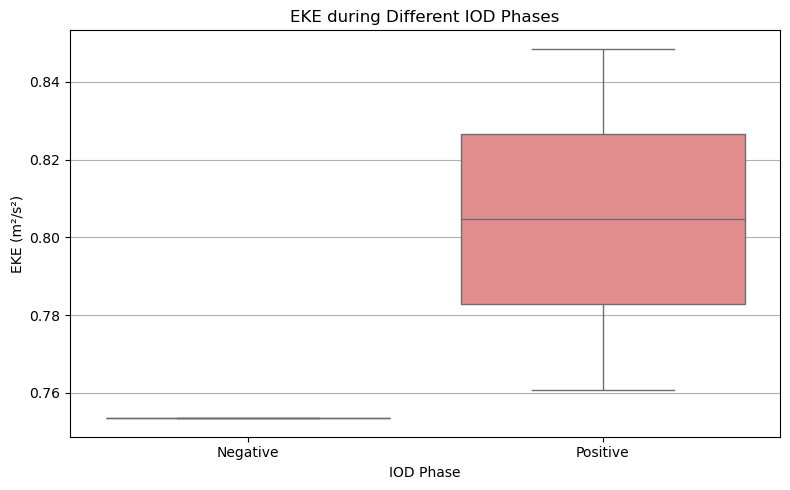

Mean EKE during Positive IOD: 0.805
Mean EKE during Negative IOD: 0.753


In [56]:
# Define IOD phases
positive_iod_years = dmi_aligned[dmi_aligned > 0.4].index
negative_iod_years = dmi_aligned[dmi_aligned < -0.4].index

# Corresponding EKE values
eke_pos_iod = eke_aligned[positive_iod_years]
eke_neg_iod = eke_aligned[negative_iod_years]

# Create DataFrame for boxplot
df_iod = pd.DataFrame({
    'EKE': list(eke_neg_iod.values) + list(eke_pos_iod.values),
    'IOD Phase': ['Negative'] * len(eke_neg_iod) + ['Positive'] * len(eke_pos_iod)
})

# Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x='IOD Phase', y='EKE', data=df_iod, palette=["lightskyblue", "lightcoral"])
plt.title('EKE during Different IOD Phases')
plt.ylabel('EKE (m²/s²)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Print mean values
print(f"Mean EKE during Positive IOD: {eke_pos_iod.mean():.3f}")
print(f"Mean EKE during Negative IOD: {eke_neg_iod.mean():.3f}")


/tmp/ipykernel_410866/3423970291.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  amo=pd.read_csv("amo.data", delim_whitespace=True, names=['YEAR','JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'],index_col=0, skiprows=46, skipfooter=5, engine='python')


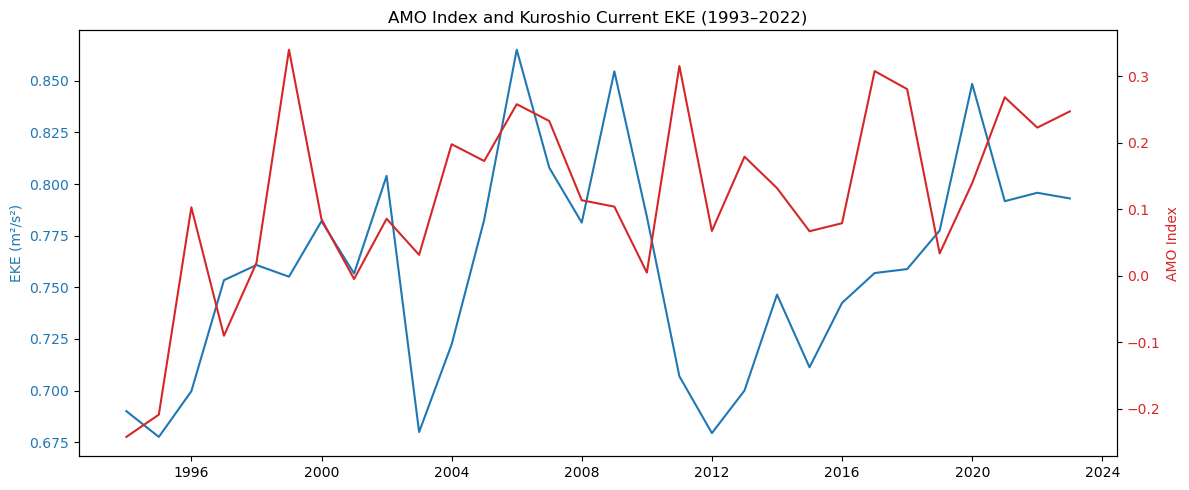

In [13]:
amo=pd.read_csv("amo.data", delim_whitespace=True, names=['YEAR','JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'],index_col=0, skiprows=46, skipfooter=5, engine='python')


# Melt the DataFrame to long format
amo_long = amo.reset_index().melt(id_vars='YEAR', var_name='MONTH', value_name='AMO')

# Drop missing values (if any)
amo_long = amo_long.dropna()
amo_annual = amo_long.groupby('YEAR')['AMO'].mean()

fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot EKE on the left y-axis
color1 = 'tab:blue'
ax1.set_ylabel('EKE (m²/s²)', color=color1)
ax1.plot(eke_annual_gs.time, eke_annual_gs, color=color1, label='EKE')
ax1.tick_params(axis='y', labelcolor=color1)

# Create a second y-axis for AMO
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_xlabel('Time')
ax2.set_ylabel('AMO Index', color=color2)
ax2.plot(eke_annual_gs.time, amo_annual, color=color2, label='AMO')
ax2.tick_params(axis='y', labelcolor=color2)

# Title and layout
plt.title('AMO Index and Kuroshio Current EKE (1993–2022)')
fig.tight_layout()
plt.grid(True, axis='x')
plt.show()

Pearson correlation: 0.37 (p = 0.046)


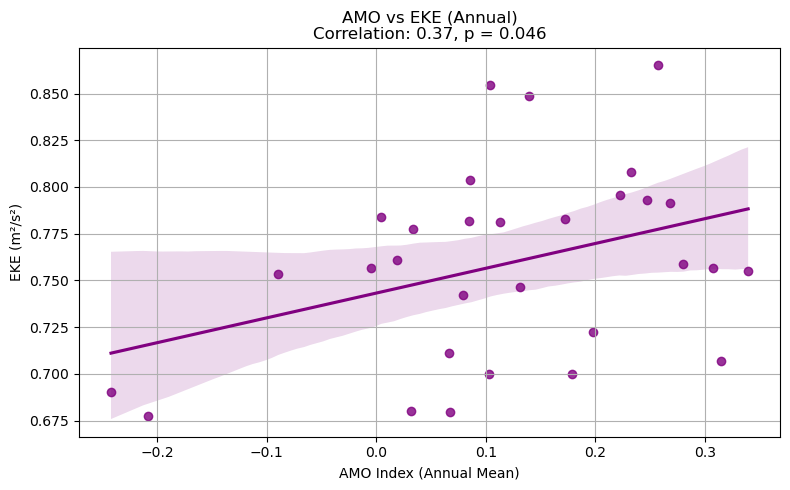

In [14]:
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure AMO annual index is in datetime format (Dec 31 each year)
amo_annual.index = pd.to_datetime(amo_annual.index.astype(str) + '-12-31')

# Convert EKE to pandas Series with datetime index
eke_series = pd.Series(eke_annual_gs.values, index=pd.to_datetime(eke_annual_gs.time.values))

# Align years
common_index = eke_series.index.intersection(amo_annual.index)
amo_aligned = amo_annual[common_index]
eke_aligned = eke_series[common_index]

# Correlation
corr, pval = pearsonr(amo_aligned, eke_aligned)
print(f"Pearson correlation: {corr:.2f} (p = {pval:.3f})")

# Regression plot
plt.figure(figsize=(8, 5))
sns.regplot(x=amo_aligned, y=eke_aligned, color='purple')
plt.xlabel('AMO Index (Annual Mean)')
plt.ylabel('EKE (m²/s²)')
plt.title(f'AMO vs EKE (Annual)\nCorrelation: {corr:.2f}, p = {pval:.3f}')
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_265924/437993949.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='AMO Phase', y='EKE', data=df_amo, palette=["lightblue", "coral"])


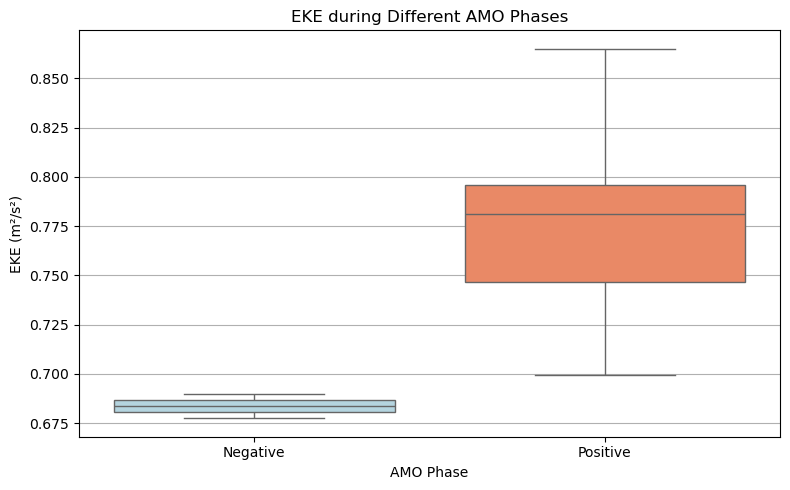

Mean EKE during Positive AMO: 0.775
Mean EKE during Negative AMO: 0.684


In [58]:
# Define AMO phases
positive_amo_years = amo_aligned[amo_aligned > 0.1].index
negative_amo_years = amo_aligned[amo_aligned < -0.1].index

# Corresponding EKE values
eke_pos_amo = eke_aligned[positive_amo_years]
eke_neg_amo = eke_aligned[negative_amo_years]

# Create DataFrame for boxplot
df_amo = pd.DataFrame({
    'EKE': list(eke_neg_amo.values) + list(eke_pos_amo.values),
    'AMO Phase': ['Negative'] * len(eke_neg_amo) + ['Positive'] * len(eke_pos_amo)
})

# Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x='AMO Phase', y='EKE', data=df_amo, palette=["lightblue", "coral"])
plt.title('EKE during Different AMO Phases')
plt.ylabel('EKE (m²/s²)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Mean values
print(f"Mean EKE during Positive AMO: {eke_pos_amo.mean():.3f}")
print(f"Mean EKE during Negative AMO: {eke_neg_amo.mean():.3f}")


/tmp/ipykernel_265924/2384284237.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  sam=pd.read_csv("sam.20crv2c.short.data", delim_whitespace=True, names=['YEAR','JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'],index_col=0, skiprows=46, skipfooter=9, engine='python')


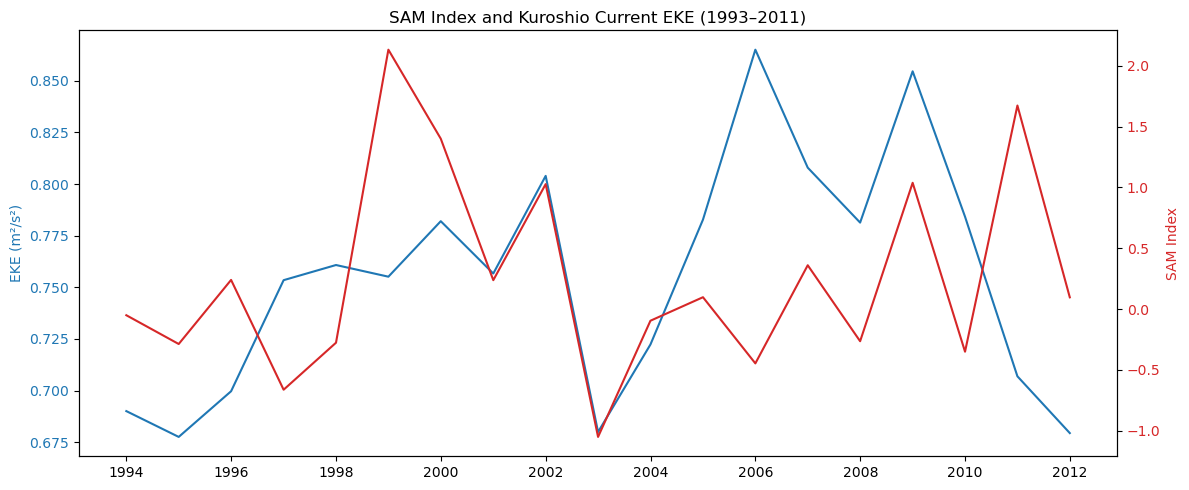

In [42]:

sam=pd.read_csv("sam.20crv2c.short.data", delim_whitespace=True, names=['YEAR','JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'],index_col=0, skiprows=46, skipfooter=9, engine='python')
# Melt the DataFrame to long format
sam_long = sam.reset_index().melt(id_vars='YEAR', var_name='MONTH', value_name='SAM')

# Drop missing values (if any)
sam_long = sam_long.dropna()
sam_annual = sam_long.groupby('YEAR')['SAM'].mean()

eke_annual_gs_11=eke_annual_gs.sel(time=slice("1993-01-01", "2011-12-31"))

fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot EKE on the left y-axis

color1 = 'tab:blue'
ax1.set_ylabel('EKE (m²/s²)', color=color1)
ax1.plot(eke_annual_gs_11.time, eke_annual_gs_11, color=color1, label='EKE')
ax1.tick_params(axis='y', labelcolor=color1)

# Create a second y-axis for SAM

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_xlabel('Time')
ax2.set_ylabel('SAM Index', color=color2)
ax2.plot(eke_annual_gs_11.time, sam_annual, color=color2, label='SAM')
ax2.tick_params(axis='y', labelcolor=color2)
# Title and layout
plt.title('SAM Index and Kuroshio Current EKE (1993–2011)')
fig.tight_layout()
plt.grid(True, axis='x')
plt.show()


Pearson correlation: 0.18 (p = 0.462)


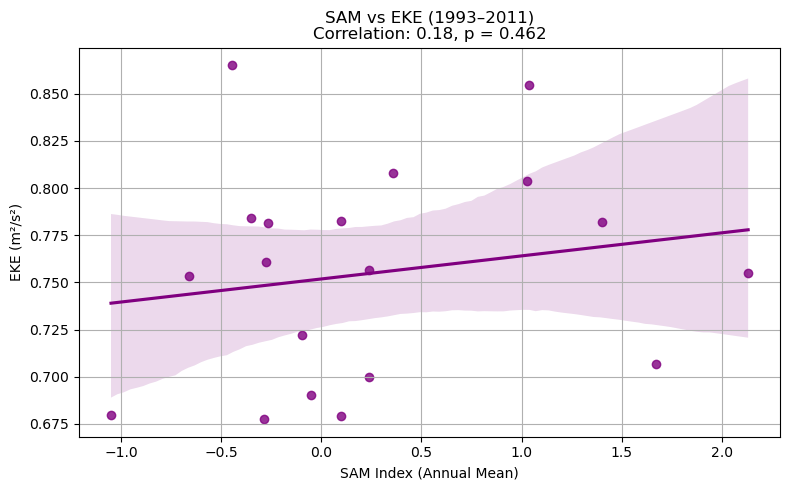

In [59]:
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

# Format SAM annual index into datetime
sam_annual.index = pd.to_datetime(sam_annual.index.astype(str) + '-12-31')

# Subset SAM to match 1993–2011 range
sam_sub = sam_annual.loc["1993":"2011"]

# Convert EKE to pandas Series for 1993–2011
eke_series_11 = pd.Series(eke_annual_gs_11.values, index=pd.to_datetime(eke_annual_gs_11.time.values))

# Align SAM and EKE
common_index = sam_sub.index.intersection(eke_series_11.index)
sam_aligned = sam_sub[common_index]
eke_aligned = eke_series_11[common_index]

# Pearson correlation
corr, pval = pearsonr(sam_aligned, eke_aligned)
print(f"Pearson correlation: {corr:.2f} (p = {pval:.3f})")

# Regression plot
plt.figure(figsize=(8, 5))
sns.regplot(x=sam_aligned, y=eke_aligned, color='purple')
plt.xlabel('SAM Index (Annual Mean)')
plt.ylabel('EKE (m²/s²)')
plt.title(f'SAM vs EKE (1993–2011)\nCorrelation: {corr:.2f}, p = {pval:.3f}')
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_265924/46121692.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='SAM Phase', y='EKE', data=df_sam, palette=["lightgreen", "violet"])


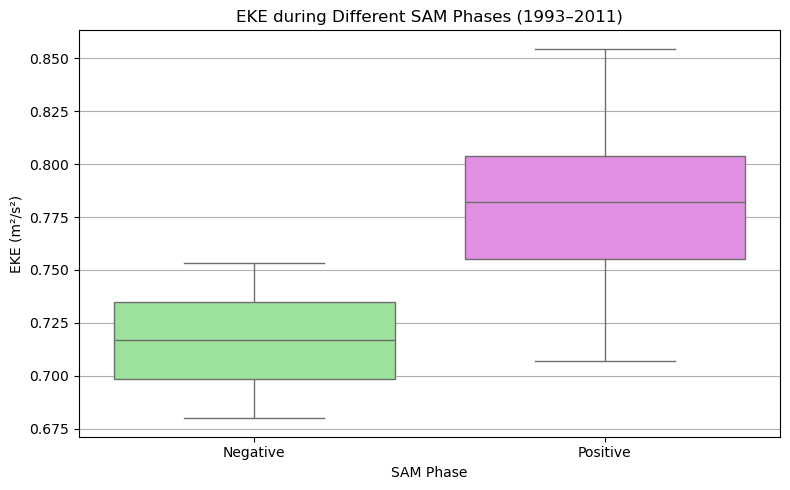

Mean EKE during Positive SAM: 0.781
Mean EKE during Negative SAM: 0.717


In [60]:
# Define SAM phases
positive_sam_years = sam_aligned[sam_aligned > 0.5].index
negative_sam_years = sam_aligned[sam_aligned < -0.5].index

# EKE values
eke_pos_sam = eke_aligned[positive_sam_years]
eke_neg_sam = eke_aligned[negative_sam_years]

# Create DataFrame for boxplot
df_sam = pd.DataFrame({
    'EKE': list(eke_neg_sam.values) + list(eke_pos_sam.values),
    'SAM Phase': ['Negative'] * len(eke_neg_sam) + ['Positive'] * len(eke_pos_sam)
})

# Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x='SAM Phase', y='EKE', data=df_sam, palette=["lightgreen", "violet"])
plt.title('EKE during Different SAM Phases (1993–2011)')
plt.ylabel('EKE (m²/s²)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Print mean EKE for both phases
print(f"Mean EKE during Positive SAM: {eke_pos_sam.mean():.3f}")
print(f"Mean EKE during Negative SAM: {eke_neg_sam.mean():.3f}")
